In [ ]:
!nvidia-smi

## 1) Installing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [2]:
# enter your personal read token

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/total_code_mixed", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--total_code_mixed-c86de67ddd2696fa
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--total_code_mixed-c86de67ddd2696fa/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 3976
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 497
    })
})


In [5]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 3976
})

## 3) Converting to dataframe

In [6]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,We don't spend one hour and rush off from our ...,1
1,Shivani my classmate,0
2,True reviewerÃƒÂ°Ã…Â¸Ã¢â€žÂ¢Ã‚Â,0
3,Royal C***yas Bangalore ÃƒÂ°Ã…Â¸Ã‹Å“Ã¢â‚¬Å¡ÃƒÂ...,2
4,*PURE DESH ME AFRA TAFRI KA MAHOOL HAI...INDIA...,2


In [7]:
test_df = aggression_dataset['test'][:]

In [8]:
train_df['Label'].value_counts()

0    2137
1    1086
2     753
Name: Label, dtype: int64

In [9]:
# 3976
# NAG-CAG-OAG (0-1-2) = 0.54-0.27-0.19

Seeing Distribution

In [10]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


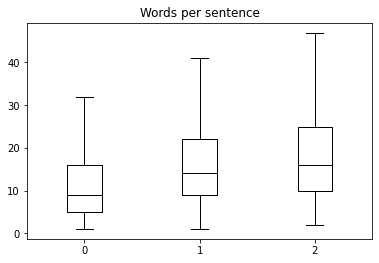

In [11]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [34]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import AutoTokenizer

In [35]:
model_ckpt = 'l3cube-pune/hing-roberta'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

loading file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/sentencepiece.bpe.model from cache at None
loading file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/tokenizer.json from cache at /home/diptesh/.cache/huggingface/transformers/41bf6bbb264c2e4f7b04414c4536c88f081eca38b97ffb2be09783c51cc83a4d.30908359aea2773a11650fe92052ca7ae49e80150f2edd0c2c241e4f6a52d6d3
loading file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/special_tokens_map.json from cache at /home/diptesh/.cache/huggingface/transformers/7ea9247c1dd1b8d11653f80e2e129855bded8ace425131655d3e26061433d56a.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
loading file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/tokenizer_config.json from cache at /home/diptesh/.cache/huggingface/transformers/b8c5e9eaa717532afa9f2b1f9c45bae3481a95930f15853dc

In [36]:
tokenizer.vocab_size

250002

In [37]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [38]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [39]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [40]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [44]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [45]:
import torch

In [46]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [47]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [49]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [50]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [51]:
from transformers import Trainer, TrainingArguments

In [52]:
# Defining hyperparameters
eval_batch_size = 8
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-code-mixed-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=4.932923543227153e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=8,
                                  weight_decay=0.17649239825343255,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.1,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="hing-roberta-code-mixed-DS",
                                  push_to_hub=True)

using `logging_steps` to initialize `eval_steps` to 497
PyTorch: setting up devices


In [53]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [54]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.17, 0.27, 0.56]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [55]:
from transformers import EarlyStoppingCallback

In [56]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [57]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/l3cube-pune/hing-roberta/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/ed92fb88ed46d9f23a6514be7a2e617a028bb7c3089be4d3be76845ba4e2a3a8.f68f7882f42cb68c7da20e8f54901da887509de49877851a4cf922843558e80d
Model config XLMRobertaConfig {
  "_name_or_path": "l3cube-pune/hing-roberta",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers":

  0%|          | 0/1988 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 16


{'loss': 1.0216, 'learning_rate': 4.111229179961814e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

Saving model checkpoint to l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-497
Configuration saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-497/config.json


{'eval_loss': 1.1362717151641846, 'eval_accuracy': 0.5392354124748491, 'eval_precision': 0.4228287841191067, 'eval_recall': 0.35120250187890917, 'eval_f1': 0.2876367806786751, 'eval_runtime': 2.519, 'eval_samples_per_second': 197.303, 'eval_steps_per_second': 12.704, 'epoch': 1.0}


Model weights saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-497/pytorch_model.bin
tokenizer config file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-497/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-497/special_tokens_map.json
tokenizer config file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/special_tokens_map.json
Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  

{'loss': 0.9085, 'learning_rate': 2.740819453307876e-05, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

Saving model checkpoint to l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-994
Configuration saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-994/config.json


{'eval_loss': 0.759894847869873, 'eval_accuracy': 0.676056338028169, 'eval_precision': 0.6247238712755955, 'eval_recall': 0.6294011787518418, 'eval_f1': 0.5902176017398537, 'eval_runtime': 2.4745, 'eval_samples_per_second': 200.852, 'eval_steps_per_second': 12.932, 'epoch': 2.0}


Model weights saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-994/pytorch_model.bin
tokenizer config file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-994/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-994/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 16


{'loss': 0.676, 'learning_rate': 1.370409726653938e-05, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

Saving model checkpoint to l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-1491
Configuration saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-1491/config.json


{'eval_loss': 0.7415341138839722, 'eval_accuracy': 0.7505030181086519, 'eval_precision': 0.6946100064461745, 'eval_recall': 0.7034458256966026, 'eval_f1': 0.6983251353770618, 'eval_runtime': 2.5236, 'eval_samples_per_second': 196.94, 'eval_steps_per_second': 12.68, 'epoch': 3.0}


Model weights saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-1491/pytorch_model.bin
tokenizer config file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-1491/tokenizer_config.json
Special tokens file saved in l3cube-pune/hing-roberta-finetuned-code-mixed-DS/checkpoint-1491/special_tokens_map.json


In [ ]:
trainer.push_to_hub()

## 8) Predictions and Results

In [ ]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

In [ ]:
preds_output_test.metrics

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

In [ ]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 